In [1]:
import location as lc
import pandas as pd

In [2]:
stopsdf = pd.read_csv("../get_stops_data/b20-stops-data/b20-north-stops-data.csv")
stopsdf.head()

StopID                             Name       AtStreet BayNo       City  \
0   51202    WB HARRISON DR NS VICTORIA DR    VICTORIA DR     N  VANCOUVER   
1   51203  NB VICTORIA DR FS FRASERVIEW DR  FRASERVIEW DR     N  VANCOUVER   
2   51204       NB VICTORIA DR FS E 61 AVE       E 61 AVE     N  VANCOUVER   
3   51205  NB VICTORIA DR FS BRIGADOON AVE  BRIGADOON AVE     N  VANCOUVER   
4   51206      NB VICTORIA DR FS UPLAND DR      UPLAND DR     N  VANCOUVER   

         Lat        Long     OnStreet    Routes  WheelchairAccess  
0  49.210673 -123.065781  HARRISON DR       020              True  
1  49.212765 -123.065964  VICTORIA DR  020, N20              True  
2  49.214832 -123.065913  VICTORIA DR  020, N20              True  
3  49.216910 -123.065874  VICTORIA DR  020, N20              True  
4  49.218398 -123.065832  VICTORIA DR  020, N20              True

Init bus stop objects from data frame

In [3]:
stops = []

# iterate through each stop and init BusStop objects
j = 0
for stop in stopsdf.iloc:
    connectedness = len(stop['Routes'].split(','))
    bstop = lc.BusStop(stop['Lat'], stop['Long'], stop['StopID'],[], j, connectedness)
    stops.append(bstop)
    j += 1


In [4]:
areadf = pd.read_csv("../stats-canada-data/DA.csv")
areadf.head()

DAuid  DApop_2016  DAtdwell_2016  DAurdwell_2016  DAarea  DAir_2016  \
0  59150307         632            273             254  0.2994          0   
1  59150308         501            223             203  0.1095          0   
2  59150309         745            299             269  0.1118          0   
3  59150310         536            310             283  0.1095          0   
4  59150311         532            199             181  0.0810          0   

       DArplamx      DArplamy    DArplat    DArplong  PRuid  CDcode  ADAcode  \
0  4.025164e+06  2.004585e+06  49.287698 -123.026031     59      15       59   
1  4.024986e+06  2.004256e+06  49.284329 -123.026065     59      15       59   
2  4.024664e+06  2.004196e+06  49.282483 -123.029585     59      15       59   
3  4.024866e+06  2.003949e+06  49.281378 -123.025534     59      15       59   
4  4.024531e+06  2.003835e+06  49.279058 -123.028871     59      15       59   

   DAcode  ERcode  CCScode  CSDcode  CMAuid  CTname  CTcode  
0     307      20       22       22     933   53.02    5286  
1     308      20       22       22     933   53.02    5286  
2     309      20       22       22     933   53.02    5286  
3     310      20       22       22     933   53.02    5286  
4     311      20       22       22     933   53.02    5286

In [5]:
areas = []

# iterate through each area and init Block objects
for area in areadf.iloc:
    area = lc.Block(area['DArplat'], area['DArplong'], area['DAuid'],int(area['DApop_2016']),int(area['DAurdwell_2016']), [])
    areas.append(area)

For each stop we find neighboring areas within $x$ km

In [6]:
dist = 0.5
# find neighborhood for each stop
for stop in stops:
    stop.findNeighbors(areas, dist)

Create a data frame for stops which contains StopID, Lat, Long and Connectedness

In [7]:
stopId = [stop.id for stop in stops]
lat = [stop.lat for stop in stops]
long = [stop.long for stop in stops]
conect = [stop.connectedness for stop in stops]
d = {'stopId':stopId, 'lat':lat, 'long':long, 'connectedness':conect}
stopVizDf = pd.DataFrame(data=d)
stopVizDf.head()

stopId        lat        long  connectedness
0   51202  49.210673 -123.065781              1
1   51203  49.212765 -123.065964              2
2   51204  49.214832 -123.065913              2
3   51205  49.216910 -123.065874              2
4   51206  49.218398 -123.065832              2

Create a data frame for all Areas which are in proximity to bus stops

In [8]:
route_areas_with_dups = []
# iterate though each stop and get areas,
# Since some stops share Areas this results in duplicates (it is supposed to be like that)
# as some stops share Areas
for stop in stops:
    route_areas_with_dups = route_areas_with_dups + stop.neighborhood

uniqueRouteAreas = set(route_areas_with_dups)

print('number of areas along the route:',len(uniqueRouteAreas))

areaId = [area.id for area in route_areas_with_dups]
lat = [area.lat for area in route_areas_with_dups]
long = [area.long for area in route_areas_with_dups]
popul = [area.pop for area in route_areas_with_dups]

d = {'areaId':areaId, 'lat':lat, 'long':long, 'pop':popul}
areaVizDf = pd.DataFrame(data=d)
areaVizDf.head()


number of areas along the route: 134


areaId        lat        long  pop
0  59151209.0  49.210165 -123.069500  667
1  59151211.0  49.213535 -123.062329  584
2  59151214.0  49.208190 -123.061474  628
3  59151215.0  49.207338 -123.063235  543
4  59153799.0  49.211912 -123.062435  285

For each area we find neighboring bus stops.

In [9]:
mostStopsPerArea = 0
area_with_most_stops = 0

for area in uniqueRouteAreas:
    area.findNeighbors(stops,dist)
    stopsPerArea = len(area.neighborhood)
    
    if stopsPerArea > mostStopsPerArea:
        mostStopsPerArea = stopsPerArea
        area_with_most_stops = area
        
print('most stops per area:', mostStopsPerArea, ', block with most stops:', area)

most stops per area: 6 , block with most stops: block id:59150749.0


For each stop we find competitor bus stops

In [10]:
for stop in stops:
    stop.findCompetitors(stops, dist)
#     print('stop id: ',stop, ' competitors:',stop.competitors)

Star formulating objective function.  
We first pick some area which is easy to locate on the map plot.
Let's pick area id = 59154001, which is at position 98 of uniqueRouteAreas list.

In [ ]:
uniqueRouteAreas = list(uniqueRouteAreas)

In [18]:
# redefine function handle for brevity
d = lc.kmDist
# pick area at pos 98
area = uniqueRouteAreas[98]
# set params of the model
beta = 1
alpha = 1
# Set weight on stops
area.neighborhood[0].weight = 0.3
area.neighborhood[1].weight = 0.2
area.neighborhood[2].weight = 0.5
# Set demand on area
area.demand = 30

S = 0

for stop in area.neighborhood:
    S += d(area,stop)**(-beta)*stop.weight**(alpha)/stop.normalization(alpha, beta, area)
print(S)

1.6743515501904045


In [12]:
# Bubble map on default map box
import plotly.express as px
import plotly.graph_objects as go
token = open("plotly-key").read()

fig = px.scatter_mapbox(areaVizDf, lat="lat", lon="long",
                            size="pop",
                            hover_name="areaId",
                            hover_data=['areaId'],
                            size_max=25,
                            center=dict(lat=49.25308, lon=-123.0687), #Center it on the middle of the bus route
                            zoom=11
                            )

fig.update_traces(
    marker=dict(opacity=0.3, # opacity of areas
                color="blue" # Color of areas
               ) 
)

fig3 =  go.Figure(go.Scattermapbox(
        name = "Bus Stops",
        lat=stopVizDf["lat"],
        lon=stopVizDf["long"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=7,
            color='black', # color of bus stops
     
       
        ),
        text=stopVizDf["stopId"],
    ))

fig.update_layout(
                  # Default style is "light"
                  mapbox_style="light",# Comment this out to revert to default map
                  mapbox_accesstoken=token,
                  title="Population Density Bubble Map",
                 ) # close layout update

fig.add_trace(fig3.data[0])

fig.show()

The plot below is produced using standard matplotlib tools

0.10880000000000223 0.08630000000000138


<ipython-input-13-e6e4b29738d5>:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



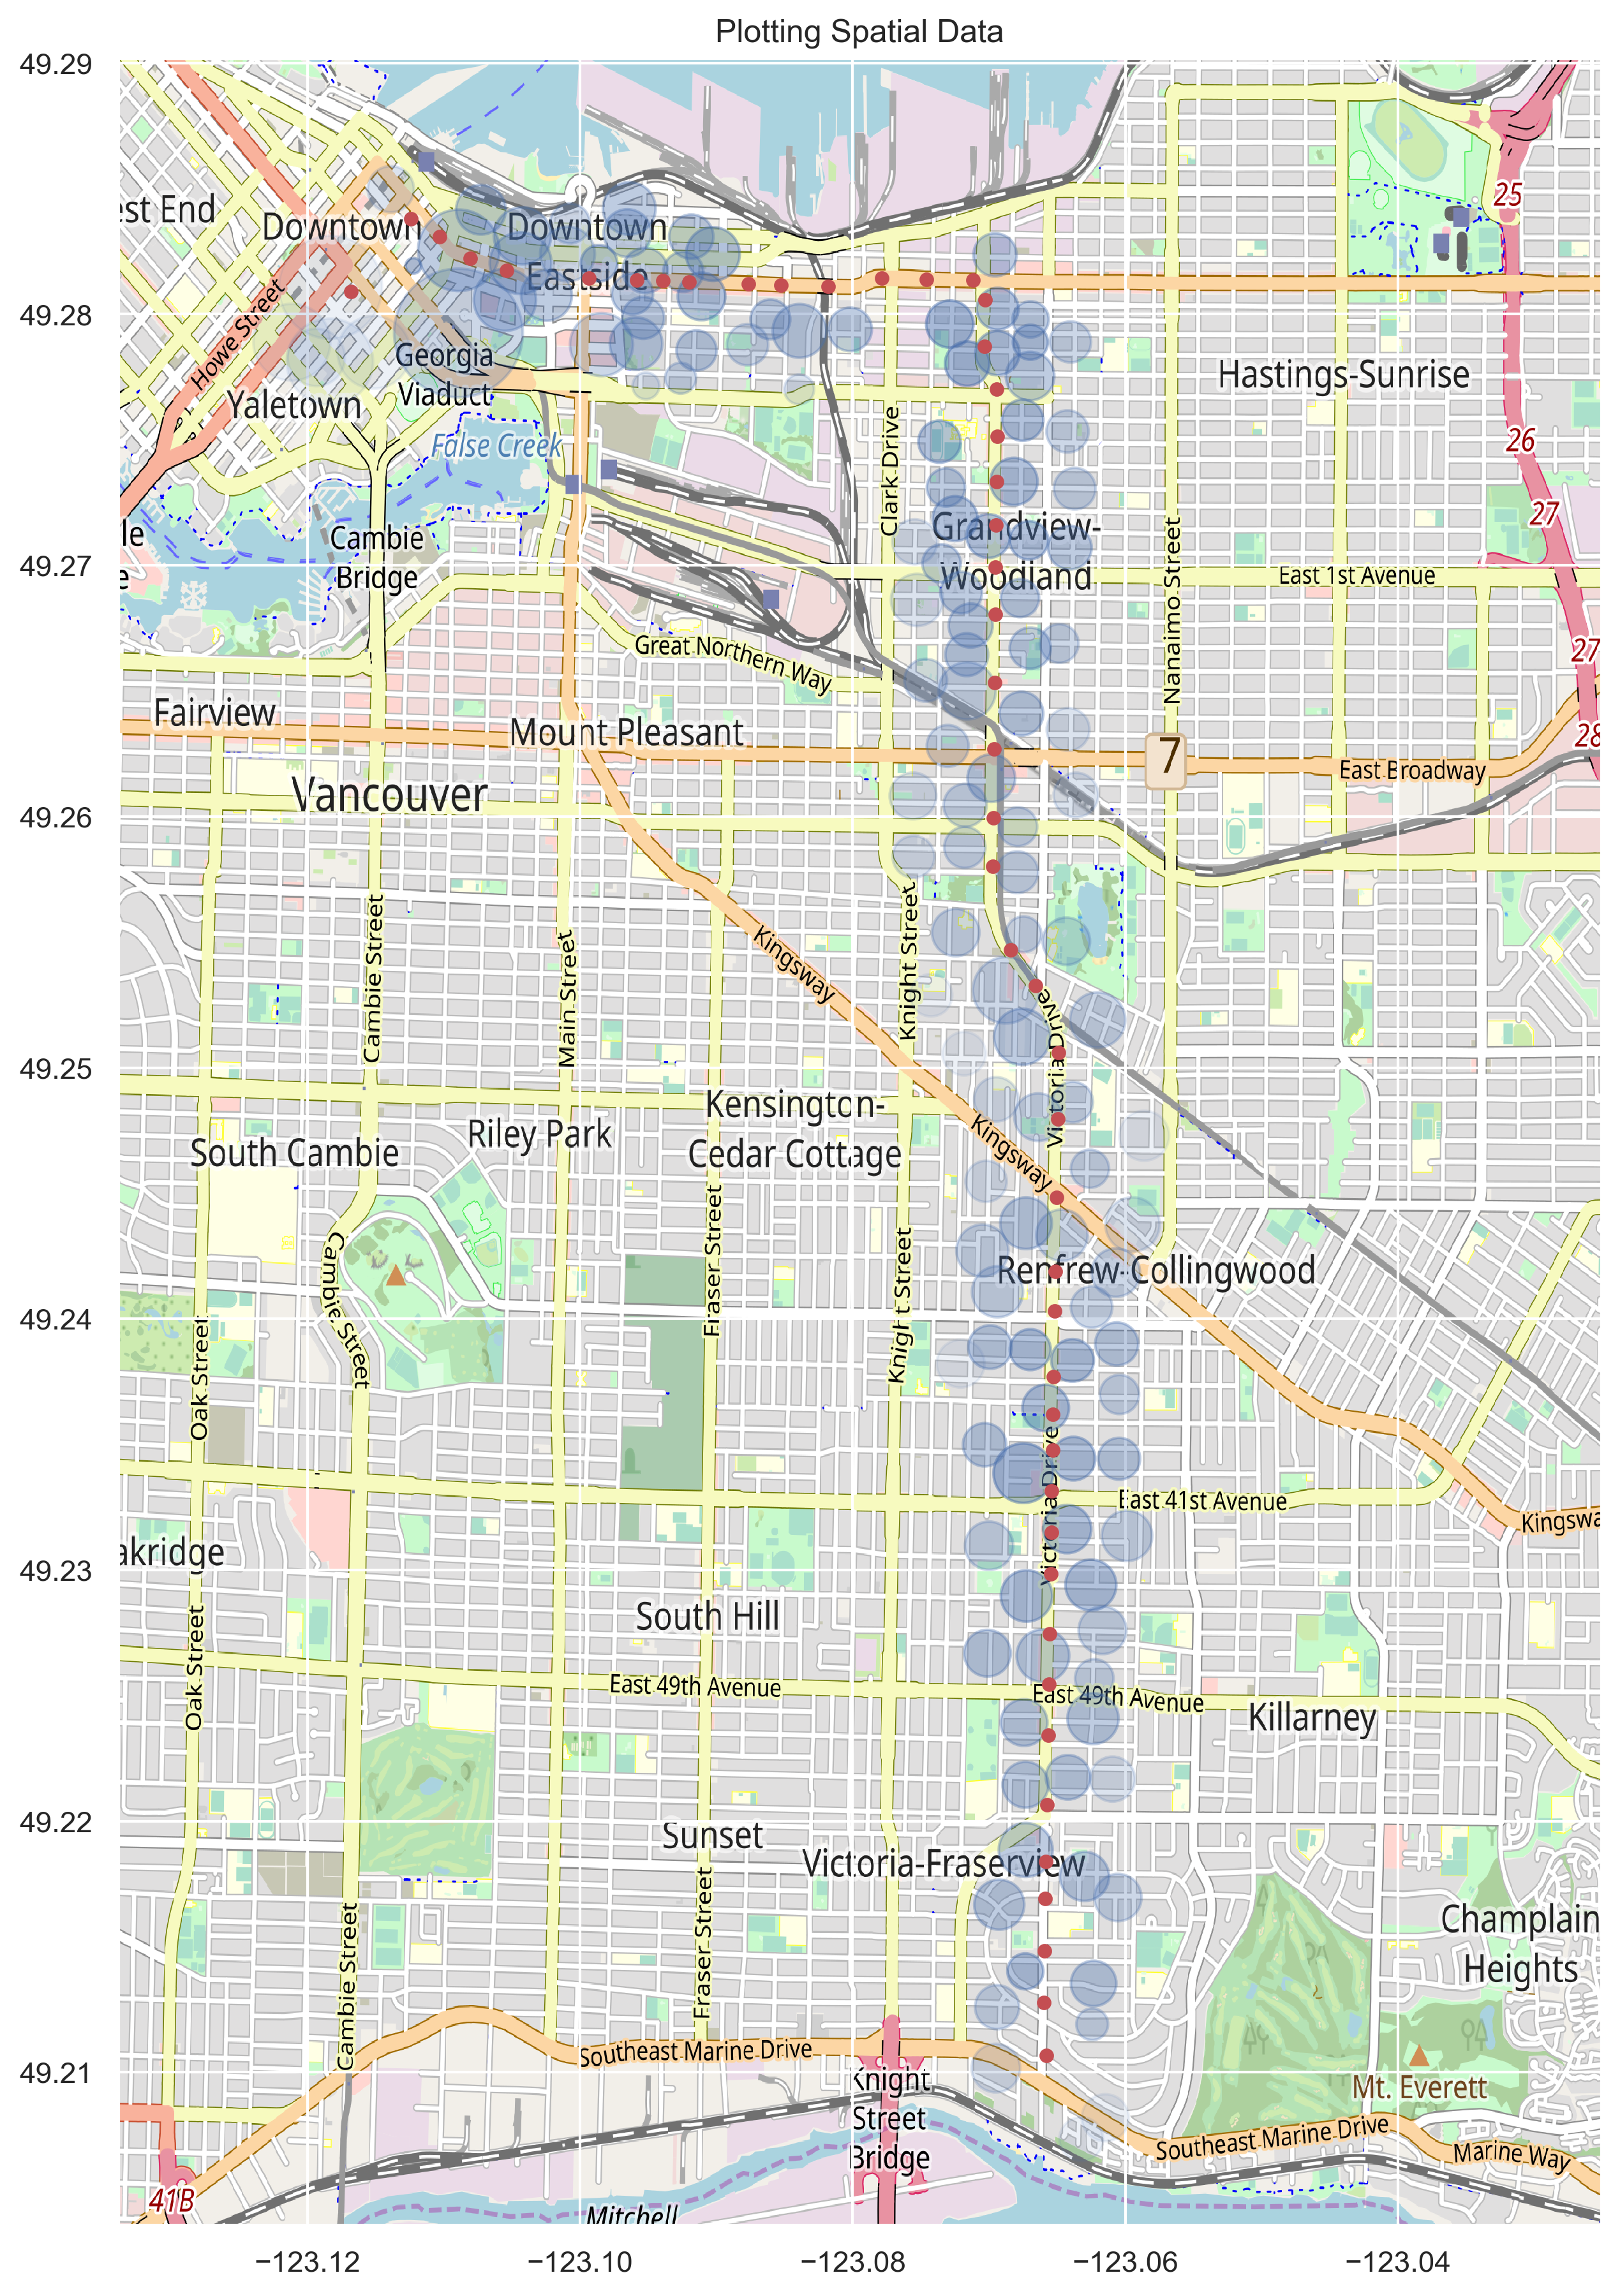

In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

mapImg = plt.imread('map.png')
bounds = {'long-min':-123.1339,'long-max': -123.0251,'lat-min': 49.2039, 'lat-max':49.2902}
box = [bounds['long-min'],bounds['long-max'],bounds['lat-min'],bounds['lat-max']]
height = box[3] - box[2]
width = box[1] - box[0]
aspect = width/height
print(width, height)

fig, ax = plt.subplots(figsize = (10,15), dpi=300)


ax.scatter(areaVizDf['long'], areaVizDf['lat'], zorder=1, alpha= 0.1, c='b', s=areaVizDf['pop']/2)
ax.scatter(stopVizDf['long'], stopVizDf['lat'], zorder=1, c='r', s=20)


ax.set_title('Plotting Spatial Data')

ax.set_xlim(bounds['long-min'],bounds['long-max'])
ax.set_ylim(bounds['lat-min'],bounds['lat-max'])

ax.imshow(mapImg, zorder=0, extent = box, interpolation='nearest', aspect='auto')
fig.show()